# **CNN Architectures**


## Objective

1. Implement **VGG** network using Pytorch
2. Implement **ResNet** using Pytorch
3. (Optional) Convolutional Neural Networks in **Torchvision**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np 
import random

from tqdm import tqdm
import time 

torch.backends.cudnn.deterministic = True # Use cudnn as deterministic mode for reproducibility
torch.backends.cudnn.benchmark = False



- Load **CIFAR-10** dataset using `torchvision` package
- For training data, we utilize appropriate **data augmentation** and **data preprocessing**
  - We utilize **Random Crop** and **Random Horizontal Filp** for data augmentation
  - Data is preprocessed by **normalizing** the data using the mean (0.4914, 0.4822, 0.4465 for each of RGB channel, respectively) and standard deviation (0.2023, 0.1994, 0.2010 for each of RGB channel, respectively) computed from training set of CIFAR-10.
- For test data, we utilize only **data preprocessing**, not **data augmentation**


In [ ]:
#Apply data augmentation and data preprocessing for training set
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4), # Random Crop: Randomly crop the part of the large image and utilize it as an augmented data 
        transforms.RandomHorizontalFlip(), # Random Horizontal Flip: Randomly flip the image and utilize it as an augmented data
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]), # Normalize the data using the given mean and standard deviation
        ])

#Apply data preprocessing for test set
transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ]) 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=200, shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


- Since the success of AlexNet in 2012, many CNN structures have been proposed for image classification problem.
  - AlexNet, VGG, Inception, ResNet, and so on.
- In this experiment, we implement **VGG** network and **ResNet**, which are most widely used CNN architecture.
  - In addition, we apply Batch Normalization to CNN and check its influence. 

- First, we implement `train` function for training and `evaluate` function for evaluation.

In [ ]:
def train(model, n_epoch, loader, optimizer, criterion, device="cpu"):
  model.train()
  for epoch in tqdm(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(input=outputs, target=labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print('Epoch {}, loss = {:.3f}'.format(epoch, running_loss/len(loader)))
  print('Training Finished')


In [ ]:
def evaluate(model, loader, device="cpu"):
  model.eval()
  total=0
  correct=0
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()
  acc = 100*correct/total
  return acc


- We also implement `reset_seed` function for reproducibility
  - `reset_seed` function sets the random seed for `torch`, `numpy` and `random` pacakges.

In [ ]:
def reset_seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

## **1. Implement VGG Network using Pytorch** 

### **VGG network**
- VGG network is a CNN architecture that developed to understand the effect of network depth on performance.
- Although the performance is a bit lower than contemporary architecture of GoogleNet (Inception v1), VGG network is used in various fields than GoogleNet dut to its simple structure.
- Many factors applied to VGG structure influenced the development of the CNN structure later.
  - Mainly utilize 3x3 convolutional layer, and increase the depth of the nerual network, not the kernel size to increase the size of receptive field (size of the area of input image used to compute a pixel of the feature)
  - Utilize padding to prevent changes in the feature size (height, width) in the convolutional layer, and adjust the feature size using pooling layer.
  - Maintain the channel size as $2^n$, and double the channel size 2 times after the pooling layer.

- The figure below is the architecture of VGG network that we use in this experiment.

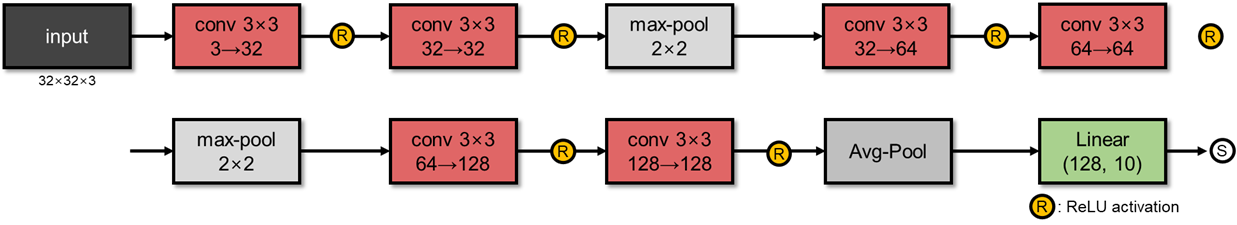

In [ ]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # Convolutional layer with 3x3 kernel. The size of feature does not change due to the usage of padding.
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size 
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) #Note that average pooling layer is not adopted in original VGG architecture. We use average pooling layer to make the architecture for experiment simple.

    self.fc = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.conv5(x)
    x = F.relu(x)
    x = self.conv6(x)
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.avg_pool(x)
    x = x.view(-1, 128)
    x = self.fc(x)
    return x

- Train and evaluate the defined VGG model using `train` function and `evaluate` function.





In [ ]:
reset_seed(0)
vgg_model = VGG().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=vgg_model.parameters(), lr=0.1, momentum=0.9)
train(model=vgg_model, n_epoch=10, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")

 10%|█         | 1/10 [00:26<03:56, 26.30s/it]

Epoch 0, loss = 2.214


 20%|██        | 2/10 [00:52<03:30, 26.29s/it]

Epoch 1, loss = 2.117


 30%|███       | 3/10 [01:19<03:04, 26.42s/it]

Epoch 2, loss = 1.804


 40%|████      | 4/10 [01:45<02:38, 26.44s/it]

Epoch 3, loss = 1.611


 50%|█████     | 5/10 [02:12<02:12, 26.47s/it]

Epoch 4, loss = 1.437


 60%|██████    | 6/10 [02:38<01:45, 26.46s/it]

Epoch 5, loss = 1.281


 70%|███████   | 7/10 [03:05<01:19, 26.60s/it]

Epoch 6, loss = 1.138


 80%|████████  | 8/10 [03:32<00:53, 26.59s/it]

Epoch 7, loss = 1.040


 90%|█████████ | 9/10 [03:58<00:26, 26.62s/it]

Epoch 8, loss = 0.978


100%|██████████| 10/10 [04:25<00:00, 26.57s/it]

Epoch 9, loss = 0.906
Training Finished


In [ ]:
vgg_acc = evaluate(vgg_model, testloader, device="cuda")
print('VGG Test accuracy: {:.2f}%'.format(vgg_acc))

VGG Test accuracy: 70.82%


## **2. Implement a Residual Network (ResNet) using Pytorch**
- Residual Network is a CNN architecture that adopts the skip connection to train the deeper neural networks.
  - Through the skip connection, we can solve the gradient vanishing problem caused by increasing the depth of neural network.
  - Performance is enhanced without additional computational complexity.
- Skip connection enables utilizing the features of lower layers directly in higher layers.
  - Even at a depth similar to the existing neural network archicture (e.g. VGG), skip connection improves performance.
- Batch normalization is also adopted in ResNet.
  - To apply batch normalization to CNN, we use `torch.nn.BatchNorm2d` class.
  - When defining batch normalization layer, we need to input the number of channels as `torch.nn.BatchNorm2d(32)`.
  - We apply the batch normalization between the convolutional layer and activation function.

- In this experiments, You should construct ResNet following the figure below.

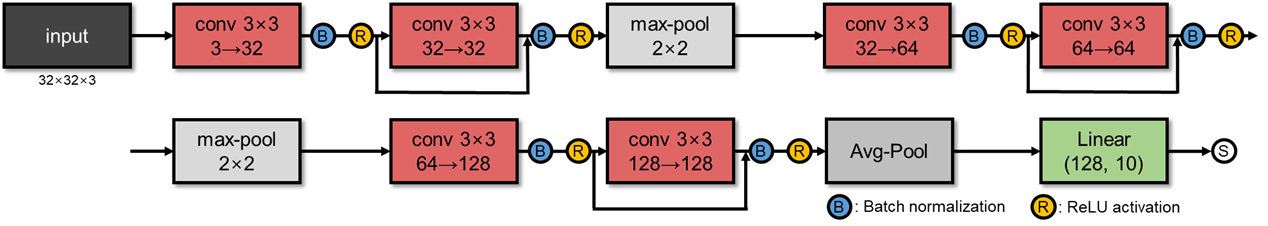

  - You should add the reisudal connections at 2nd, 4th, 6th convolutional layer.
  - You should add the batch normalization layer right after each convolutional layer.

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.norm1=
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.norm2= 

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.norm3=
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.norm4= 

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.norm5=
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.norm6= 

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))

    self.fc = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    ######### Modify the forward method to utilize skip connection and batch normalization #########

    # Task 1. Add residual connections at conv2, conv4, and conv6 with the same number of input channels and output channels.
    # Task 2. Add the forward propagation through batch normalization layer
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.conv5(x)
    x = F.relu(x)
    x = self.conv6(x)
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.avg_pool(x)
    x = x.view(-1, 128)
    x = self.fc(x)
    return x

- Train and evaluate the defined ResNet model using `train` function and `evaluate` function.
- Residual connection and batch normalization improves performance with only a small amount of parameter increase.

In [ ]:
reset_seed(0)
resnet_model = ResNet().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=resnet_model.parameters(), lr=0.1, momentum=0.9)
train(model=resnet_model, n_epoch=10, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")


In [ ]:
resnet_acc = evaluate(resnet_model, testloader, device="cuda")
print('ResNet Test accuracy: {:.2f}%'.format(resnet_acc))

## **3. (Optional) Convolutional Neural Networks in Torchvision**

- `torchvision` is a package that provides tools to deal with computer vision using pytorch.
- `torchvision` provides many tools such as dataset, neural network models, and image processing techniques.
- We try to use following CNN architectures and pretrained models provided by `torchvision` package
  - VGG-16 network for image classification
  - (Pretrained) Faster R-CNN for object detection
  - (Pretrained) Deeplab V3 for semantic segmentation

In [ ]:
import torchvision.models as models # Pre-defined models
from google.colab.patches import cv2_imshow # Packages for visualization
import cv2
import os

### **3.1. (Optional) Image Classification using Torchvision package**
- **VGG-16** is a widely utilized CNN architecture for image classification
- Since it requires very long training time, we only train the model for 1 epoch in here.
- We can save parameters of the trained model using `torch.save` function and `state_dict` method.


In [ ]:
vgg16 = models.vgg16(num_classes = 10).to("cuda")
optimizer = optim.SGD(params=vgg16.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=vgg16, n_epoch=1, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda") # Due to the computation time, we experiment with 1 epoch in here.
vgg16_acc = evaluate(vgg16, testloader, device="cuda")
print('VGG-16 Test accuracy: {:.2f}%'.format(vgg16_acc))
torch.save({'model_state_dict':vgg16.state_dict()},'save.tar')  # Trained model can be saved using torch.save

- We provide the pretrained VGG model trained for 200 epoches.
  - We utilized proper $l2$ regularization and learning rate scheduling for pretraining
- Saved parameters of trained model can be loaded using `torch.load` function and `load_state_dict` method. 

In [ ]:
!pip install gdown
!gdown --id 1eeGKlJlRZXvCbT8icq_xW0vyfTvXvEEQ

checkpoint = torch.load('VGG16.tar', map_location = 'cuda')
vgg16.load_state_dict(checkpoint['model_state_dict'])
vgg16_acc = evaluate(vgg16, testloader, device="cuda")
print('VGG-16 Test accuracy: {:.2f}%'.format(vgg16_acc))

### **3.2. (Optional) Object Detection using Torchvision package**
- Object detection is a computer vision problem that detects multiple objects in a picture.

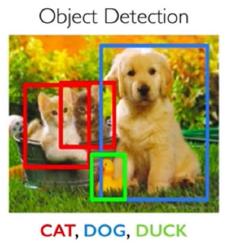

- R-CNN, Fast R_CNN, Faster R-CNN, Mask R-CNN and YOLO are the CNN architectures for object detection
  - In this experiment, we utilize the pretrained **Faster R-CNN** provided by torchvision.
- MS-COCO is a dataset widely used for training and evaluating the object detection algorithms

In [ ]:
# Downloading MS-COCO dataset 
if not os.path.exists('val2017'):
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !wget http://images.cocodataset.org/zips/val2017.zip  
  !unzip -q val2017.zip
  !unzip -q annotations_trainval2017.zip
  !rm *.zip

In [ ]:
detection_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size = 800).to("cuda").eval() # By input 'True' in 'pretrained' argument, we can load pretrained model.

In [ ]:
coco_categories = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
] # List of classes in MS-COCO dataset
np.random.seed(2020)
COLORS = np.random.uniform(0, 255, size=(len(coco_categories), 3)) # We randomly assign different colors for different classes.

def detect(image, model, device, detection_threshold): 
  transform = transforms.ToTensor()
  image = transform(image) # Convert image to tensor
  image = image.to(device)
  image = image.unsqueeze(0) 
  outputs = model(image) #  Obtain the prediction result of faster R-CNN model.

  pred_classes = [coco_categories [i] for i in outputs[0]['labels'].cpu().numpy()] # From the 'labels' item of 'outputs[0]', obtain the list of classes that appear in image.

  pred_scores = outputs[0]['scores'].detach().cpu().numpy() # From the 'scores' item of 'outputs[0]', obtain the list of confidence score of the prediction results.
  pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy() # From the 'boxes' item of 'outputs[0]', obtain the locations of bounding boxes. 
  boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32) # Select bounding boxes that have confidence score above threshold. 
  return boxes, pred_classes, outputs[0]['labels']


def draw_boxes(boxes, classes, labels, image):
  # read the image with OpenCV
  for i, box in enumerate(boxes):
      color = COLORS[labels[i]] 
      cv2.rectangle(
          image,
          (int(box[0]), int(box[1])),
          (int(box[2]), int(box[3])),
          color, 2
      ) # Mark bounding box on the image using the color of the class in the box. 
      cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                  lineType=cv2.LINE_AA) # Mark the class of the object with the text on the image.
  return image

In [ ]:
test_image = 'val2017/000000000139.jpg' # Select a image from the validatiaon set of MS-COCO dataset. 
img = cv2.imread(test_image, cv2.IMREAD_COLOR) # Read image using OpenCV pacakge

boxes, classes, labels = detect(img, detection_model, 'cuda', 0.8) 
image = draw_boxes(boxes, classes, labels, img)# Visualize the prediction result
cv2_imshow(image)

### **3.3. (Optional) Semantic Segmentation using Torchvision package**
- Semantic segmentation is a computer vision problem that classifies all pixels in an image by a given classes.

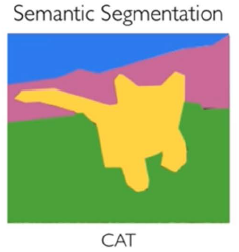

- Fully Convolutional Network (FCN), U-Net and Deeplab (V1,V2,V3,V3+) are the CNN architectures for semantic segmentation 
  - In this experiment, we utilize the pretrained **Deeplab V3** model provided by torchvision.
- PASCAL-VOC is a dataset widely used for training and evaluating the semantic segmentation algorithms

In [ ]:
# Downloading PASCAL-VOC dataset 
import zipfile
if not os.path.exists('PascalVOC2012.zip'):
  !wget https://data.deepai.org/PascalVOC2012.zip
  VOCzip = zipfile.ZipFile('PascalVOC2012.zip')
  VOCzip.extract('VOC2012/JPEGImages/2007_000032.jpg')

In [ ]:
segmentation_model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval().to('cuda') # By input 'True' in 'pretrained' argument, we can load pretrained model.

In [ ]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]) 
# We assign different colors for different classes
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb # Generate masks with the given color for each class.

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.486, 0.456, 0.406], std= [0.229, 0.224, 0.225])
                                ])

def segment(image, model, device):
  # Conduct segmentation and obtain the segmentation mask where the different objects are marked with different colors.
  image = transform(image)
  image = image.to(device)
  image = image.unsqueeze(0)
  outputs = model(image)['out']
  output_map = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(output_map)
  return rgb


In [ ]:
test_image = 'VOC2012/JPEGImages/2007_000032.jpg' # Select a image from PASCAL-VOC dataset. 
img = cv2.imread(test_image, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (512, 512)) # Read and resize image using Open CV package. 
# Obtain and visualize prediction result.
segmap = segment(resized_img, segmentation_model, 'cuda')
overlay_img = cv2.addWeighted(resized_img, 0.5, segmap, 0.5,0) # Visualize the result by overlapping image and predicted mask. 
cv2_imshow(overlay_img) 
cv2_imshow(segmap) # Visualize only the predicted mask.

## **4.Reference**
https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/

https://colab.research.google.com/github/spmallick/learnopencv/blob/master/PyTorch-Segmentation-torchvision/intro-seg.ipynb#scrollTo=5GA_GNohUHnR

